Getting abstracts for making our corpus

In [ ]:
!pip install Bio
!pip install BeautifulSoup

In [4]:
import re
import requests
import time
from Bio import Entrez
import nltk
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LdaModel
from collections import Counter
from textblob import TextBlob
from wordcloud import WordCloud

In [8]:
import requests
from Bio import Entrez

base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
retmax = 10
api_key = '2a712e0d47f3436ef738ec764ade7b1bee09'

# Define the range of years you want to search
start_year = 2010
end_year = 2020

# Collect PubMed IDs by year
all_ids_by_year = {}

for year in range(start_year, end_year + 1):
    ids_for_year = []
    for retstart in range(0, 10, retmax):
        search_term = f"secondary metabolite AND plants AND {year}[Publication Date]"
        search_url = f"{base_url}esearch.fcgi?db=pubmed&term={search_term}&retmax={retmax}&retstart={retstart}&retmode=json"

        if api_key:
            search_url += f"&api_key={api_key}"

        search_response = requests.get(search_url)
        search_data = search_response.json()

        if "ERROR" in search_data["esearchresult"]:
            print(search_data["esearchresult"]["ERROR"])
            break

        current_ids = search_data["esearchresult"]["idlist"]
        ids_for_year.extend(current_ids)

        if len(current_ids) < retmax:
            break

    all_ids_by_year[year] = ids_for_year

# Fetch abstracts for the collected PubMed IDs
def fetch_abstracts_by_year(pubmed_ids_by_year):
    Entrez.email = "your_email@example.com"  # Provide your email address for NCBI access

    details_by_year = {}

    for year, pubmed_ids in pubmed_ids_by_year.items():
        handle = Entrez.efetch(db="pubmed", id=','.join(map(str, pubmed_ids)), retmode="xml")
        records = Entrez.read(handle)

        abstracts = {}

        for record in records['PubmedArticle']:
            pubmed_id = record['PubmedData']['ArticleIdList'][0]

            abstract_text = ''
            if 'Abstract' in record['MedlineCitation']['Article']:
                abstract_text = record['MedlineCitation']['Article']['Abstract']['AbstractText']

            abstracts[pubmed_id] = {'Abstract': abstract_text}

        details_by_year[year] = abstracts

    return details_by_year


abstracts_by_year = fetch_abstracts_by_year(all_ids_by_year)

# Crear y escribir en un archivo CSV
with open('abstracts_by_year.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Year', 'PubMed ID', 'Abstract'])  # Encabezados del CSV

    for year, abstracts in abstracts_by_year.items():
        for pubmed_id, data in abstracts.items():
            writer.writerow([year, pubmed_id, data.get('Abstract', 'N/A')])


In [16]:
import pandas as pd
train= pd.read_csv("/content/abstracts_by_year.csv")
train.head()

,Year,PubMed ID,Abstract
0,2010,23059762,['Plumbagin is one of the simplest plant secon...
1,2010,21765818,['Secondary metabolites provide a potential so...
2,2010,21749378,[StringElement('Radix Bupleuri represents one ...
3,2010,25213963,"['Phenolic compounds, ubiquitous in plants, ar..."
4,2010,21637580,"[""Cannabinoids, flavonoids, and stilbenoids ha..."


In [17]:
train.shape

(110, 3)

Cleaning our corpus, getting rid of stop words and other characters

In [18]:
# Import BeautifulSoup into your workspace
from bs4 import BeautifulSoup

# Initialize the BeautifulSoup object on a single movie review
example1 = BeautifulSoup(train["Abstract"][0], "html.parser" )
print(example1.get_text())

['Plumbagin is one of the simplest plant secondary metabolite of three major phylogenic families viz. Plumbaginaceae, Droseraceae, and Ebenceae, and exhibits highly potent biological activities, including antioxidant, antiinflammatory, anticancer, antibacterial, and antifungal activities. Recent investigations indicate that these activities arise mainly out of its ability to undergo redox cycling, generating reactive oxygen species and chelating trace metals in biological system. The compound is endowed with a property to inhibit the drug efflux mechanism in drug-resistant bacteria, thereby allowing intracellular accumulation of the potent drug molecules. An interesting bioactivity exhibited by this compound is the elimination of stringent, conjugative, multidrug-resistant plasmids from several bacterial strains including opportunistic bacteria, such as Acinetobacter baumannii. Moreover, plumbagin effectively induces apoptosis and causes cell cycle arrest, which is, in part, due to the

In [19]:
import re
# Use regular expressions to do a find-and-replace
letters_only = re.sub("[^a-zA-Z]",           # The pattern to search for
                      " ",                   # The pattern to replace it with
                      example1.get_text() )  # The text to search
print (letters_only)

  Plumbagin is one of the simplest plant secondary metabolite of three major phylogenic families viz  Plumbaginaceae  Droseraceae  and Ebenceae  and exhibits highly potent biological activities  including antioxidant  antiinflammatory  anticancer  antibacterial  and antifungal activities  Recent investigations indicate that these activities arise mainly out of its ability to undergo redox cycling  generating reactive oxygen species and chelating trace metals in biological system  The compound is endowed with a property to inhibit the drug efflux mechanism in drug resistant bacteria  thereby allowing intracellular accumulation of the potent drug molecules  An interesting bioactivity exhibited by this compound is the elimination of stringent  conjugative  multidrug resistant plasmids from several bacterial strains including opportunistic bacteria  such as Acinetobacter baumannii  Moreover  plumbagin effectively induces apoptosis and causes cell cycle arrest  which is  in part  due to the

In [20]:
lower_case = letters_only.lower()        # Convert to lower case
words = lower_case.split()               # Split into words
print(words)

['plumbagin', 'is', 'one', 'of', 'the', 'simplest', 'plant', 'secondary', 'metabolite', 'of', 'three', 'major', 'phylogenic', 'families', 'viz', 'plumbaginaceae', 'droseraceae', 'and', 'ebenceae', 'and', 'exhibits', 'highly', 'potent', 'biological', 'activities', 'including', 'antioxidant', 'antiinflammatory', 'anticancer', 'antibacterial', 'and', 'antifungal', 'activities', 'recent', 'investigations', 'indicate', 'that', 'these', 'activities', 'arise', 'mainly', 'out', 'of', 'its', 'ability', 'to', 'undergo', 'redox', 'cycling', 'generating', 'reactive', 'oxygen', 'species', 'and', 'chelating', 'trace', 'metals', 'in', 'biological', 'system', 'the', 'compound', 'is', 'endowed', 'with', 'a', 'property', 'to', 'inhibit', 'the', 'drug', 'efflux', 'mechanism', 'in', 'drug', 'resistant', 'bacteria', 'thereby', 'allowing', 'intracellular', 'accumulation', 'of', 'the', 'potent', 'drug', 'molecules', 'an', 'interesting', 'bioactivity', 'exhibited', 'by', 'this', 'compound', 'is', 'the', 'elim

In [21]:
# Enter Download then stopwords.
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
print (stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [23]:
# Remove stop words from "words"
words = [w for w in words if not w in stopwords.words("english")]
print (words)

['plumbagin', 'one', 'simplest', 'plant', 'secondary', 'metabolite', 'three', 'major', 'phylogenic', 'families', 'viz', 'plumbaginaceae', 'droseraceae', 'ebenceae', 'exhibits', 'highly', 'potent', 'biological', 'activities', 'including', 'antioxidant', 'antiinflammatory', 'anticancer', 'antibacterial', 'antifungal', 'activities', 'recent', 'investigations', 'indicate', 'activities', 'arise', 'mainly', 'ability', 'undergo', 'redox', 'cycling', 'generating', 'reactive', 'oxygen', 'species', 'chelating', 'trace', 'metals', 'biological', 'system', 'compound', 'endowed', 'property', 'inhibit', 'drug', 'efflux', 'mechanism', 'drug', 'resistant', 'bacteria', 'thereby', 'allowing', 'intracellular', 'accumulation', 'potent', 'drug', 'molecules', 'interesting', 'bioactivity', 'exhibited', 'compound', 'elimination', 'stringent', 'conjugative', 'multidrug', 'resistant', 'plasmids', 'several', 'bacterial', 'strains', 'including', 'opportunistic', 'bacteria', 'acinetobacter', 'baumannii', 'moreover'

In [24]:
#Now we are going to do our first class
class KaggleWord2VecUtility(object):
    """KaggleWord2VecUtility is a utility class for processing raw HTML text into segments for further learning"""

    @staticmethod
    def review_to_wordlist( review, remove_stopwords=False ):
        # Function to convert a document to a sequence of words,
        # optionally removing stop words.  Returns a list of words.
        #
        # 1. Remove HTML
        review_text = BeautifulSoup(review,"html.parser"  ).get_text()
        #
        # 2. Remove non-letters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        #
        # 3. Convert words to lower case and split them
        words = review_text.lower().split()
        #
        # 4. Optionally remove stop words (false by default)
        if remove_stopwords:
            stops = set(stopwords.words("english"))
            words = [w for w in words if not w in stops]
        #
        # 5. Return a list of words
        return(words)

    # Define a function to split a review into parsed sentences
    @staticmethod
    def review_to_sentences( review, tokenizer, remove_stopwords=False ):
        # Function to split a review into parsed sentences. Returns a
        # list of sentences, where each sentence is a list of words
        #
        # 1. Use the NLTK tokenizer to split the paragraph into sentences
        raw_sentences = tokenizer.tokenize(review.strip())
        #
        # 2. Loop over each sentence
        sentences = []
        for raw_sentence in raw_sentences:
            # If a sentence is empty, skip it
            if len(raw_sentence) > 0:
                # Otherwise, call review_to_wordlist to get a list of words
                sentences.append( KaggleWord2VecUtility.review_to_wordlist( raw_sentence, remove_stopwords ))
        #
        # Return the list of sentences (each sentence is a list of words,
        # so this returns a list of lists
        return sentences


In [25]:
clean_review_word = KaggleWord2VecUtility.review_to_wordlist \
        ( train["Abstract"][0], True )
clean_review_sentence = KaggleWord2VecUtility.review_to_wordlist \
        ( train["Abstract"][0], True )


In [26]:
# Get the number of reviews based on the dataframe column size
num_reviews = train["Abstract"].size
print(num_reviews)



110


In [29]:
print ("Cleaning and parsing the training set publication Abstract...\n")
clean_train_reviews = []
for i in range( 0, len(train["Abstract"])):
    if( (i+1)%1000 == 0 ):
        print ("Abstract %d of %d\n" % ( i+1, num_reviews )  )
    clean_train_reviews.append(" ".join(KaggleWord2VecUtility.review_to_wordlist(train["Abstract"][i], True)))

Cleaning and parsing the training set publication Abstract...



In [30]:
clean_train_reviews[0:5]

['plumbagin one simplest plant secondary metabolite three major phylogenic families viz plumbaginaceae droseraceae ebenceae exhibits highly potent biological activities including antioxidant antiinflammatory anticancer antibacterial antifungal activities recent investigations indicate activities arise mainly ability undergo redox cycling generating reactive oxygen species chelating trace metals biological system compound endowed property inhibit drug efflux mechanism drug resistant bacteria thereby allowing intracellular accumulation potent drug molecules interesting bioactivity exhibited compound elimination stringent conjugative multidrug resistant plasmids several bacterial strains including opportunistic bacteria acinetobacter baumannii moreover plumbagin effectively induces apoptosis causes cell cycle arrest part due inactivation nf b cancer cells therefore suggested designing hybrid drug molecules plumbagin combining appropriate anticancer agents may lead generation novel potent 

Visualization

In [31]:
!pip install wordcloud

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

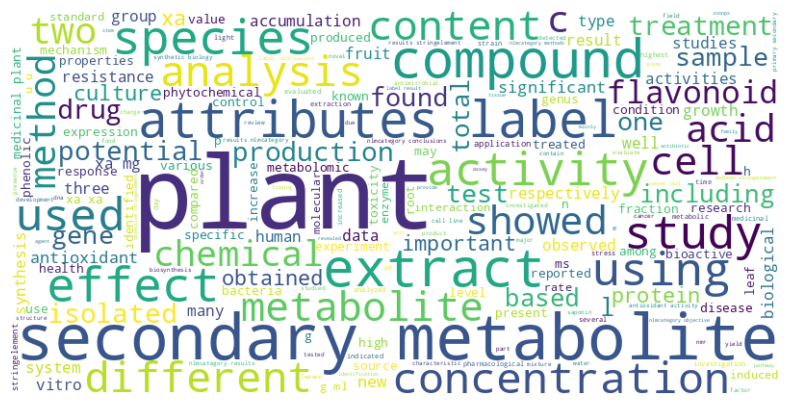

In [33]:
cleaned_reviews = " ".join(clean_train_reviews)
# Create a WordCloud object with custom settings
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis", max_words=200).generate(cleaned_reviews)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Turn off axis labels
plt.show()

In [34]:
!pip install gensim

In [35]:
from gensim import corpora
from gensim.models import LdaModel

In [36]:
# Tokenizing the reviews
tokenized_reviews = [review.split() for review in clean_train_reviews]


In [37]:
dictionary = corpora.Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]


In [38]:
NUM_TOPICS = 10  # Adjust this based on your needs
lda_model = LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)


In [41]:
topics = lda_model.print_topics(num_words=7)
for topic in topics:
    print(topic)

(0, '0.007*"silico" + 0.006*"plant" + 0.006*"compounds" + 0.006*"activity" + 0.006*"effects" + 0.006*"end" + 0.006*"toxin"')
(1, '0.016*"plant" + 0.008*"secondary" + 0.007*"used" + 0.007*"metabolites" + 0.006*"host" + 0.005*"mcpde" + 0.005*"compounds"')
(2, '0.011*"plant" + 0.008*"u" + 0.008*"metabolites" + 0.008*"extract" + 0.007*"plants" + 0.006*"activity" + 0.006*"secondary"')
(3, '0.012*"stringelement" + 0.012*"nlmcategory" + 0.012*"label" + 0.011*"attributes" + 0.008*"results" + 0.008*"secondary" + 0.007*"dna"')
(4, '0.012*"species" + 0.009*"c" + 0.009*"metabolites" + 0.008*"plant" + 0.007*"secondary" + 0.007*"study" + 0.006*"two"')
(5, '0.014*"xa" + 0.007*"hesperidin" + 0.007*"kg" + 0.007*"mg" + 0.006*"treated" + 0.006*"storage" + 0.006*"stress"')
(6, '0.013*"xa" + 0.011*"metabolites" + 0.011*"species" + 0.010*"activity" + 0.008*"secondary" + 0.008*"study" + 0.006*"plants"')
(7, '0.009*"secondary" + 0.008*"metabolites" + 0.007*"extracts" + 0.007*"ms" + 0.006*"activity" + 0.006*"s

if we ignore "plant" as a relevant term we can se that:

1: refers to toxic counpunds

2: secondary metabolites

3: a bucnh of words that are too general

4: metabolites in different speies

5: hesperidin and stress

6: and other general subset

7: study of secondary metabolite extracts


9: amycolatopsis, studies about nitrogen and stach


We could filter some words to make this even better, for example:
plant, used, study.
are termns that are very commonly used and doesnt give us relevant information.

In [40]:
for i, review in enumerate(clean_train_reviews[:10]):  # Displaying topics for the first 10 reviews
    bow = dictionary.doc2bow(review.split())
    topic_scores = lda_model[bow]
    dominant_topic = sorted(topic_scores, key=lambda x: x[1], reverse=True)[0]
    print(f"Review {i + 1} has dominant topic {dominant_topic[0]} with probability {dominant_topic[1]:.4f}")

Review 1 has dominant topic 2 with probability 0.9931
Review 2 has dominant topic 1 with probability 0.9929
Review 3 has dominant topic 6 with probability 0.9944
Review 4 has dominant topic 1 with probability 0.7414
Review 5 has dominant topic 3 with probability 0.9897
Review 6 has dominant topic 8 with probability 0.9938
Review 7 has dominant topic 3 with probability 0.9909
Review 8 has dominant topic 1 with probability 0.7841
Review 9 has dominant topic 2 with probability 0.9913
Review 10 has dominant topic 7 with probability 0.8249


Clustering


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.85, max_features=25000, stop_words='english')
X = vectorizer.fit_transform(clean_train_reviews)

In [43]:
from sklearn.cluster import KMeans

# Define the number of clusters you want
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [44]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(n_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i+1}:")
    print(', '.join(top_ten_words), '\n')

Cluster 1:
root, dw, elicitation, nitrogen, starch, accumulation, nutrient, elicitor, saponin, cultures 

Cluster 2:
light, callus, flavonoids, alad, glycyrrhiza, important, pkss, cannabis, sulfur, metr 

Cluster 3:
species, phylogenetic, alternar, phoma, globosum, tree, caterpillar, assemblages, herbivory, host 

Cluster 4:
stricta, arabia, saudi, trichomes, study, medicinal, changing, united, glabrous, uae 

Cluster 5:
bark, ethanolic, extracts, extract, activity, mtcc, tampoi, gc, alsinoides, evolvulus 

Cluster 6:
extracts, mg, ml, extract, andrographolide, toxicity, flacourtin, kg, fusarium, brine 

Cluster 7:
xa, mg, fold, pes, acid, hesperidin, cf, lichen, ga, gymnemic 

Cluster 8:
nlmcategory, stringelement, label, attributes, methods, results, conclusions, background, objective, docking 

Cluster 9:
content, sprouts, fertilization, glucosinolate, treated, hypophyllanthin, phyllanthin, smdxr, tanshinone, germination 

Cluster 10:
metabolomics, np, ms, metabolic, teas, primary, 

In [45]:
for i, review in enumerate(clean_train_reviews[:10]):  # Displaying the first 10 reviews as an example
    print(f"Review {i+1} (Cluster {clusters[i]+1}): {review}\n")

Review 1 (Cluster 13): plumbagin one simplest plant secondary metabolite three major phylogenic families viz plumbaginaceae droseraceae ebenceae exhibits highly potent biological activities including antioxidant antiinflammatory anticancer antibacterial antifungal activities recent investigations indicate activities arise mainly ability undergo redox cycling generating reactive oxygen species chelating trace metals biological system compound endowed property inhibit drug efflux mechanism drug resistant bacteria thereby allowing intracellular accumulation potent drug molecules interesting bioactivity exhibited compound elimination stringent conjugative multidrug resistant plasmids several bacterial strains including opportunistic bacteria acinetobacter baumannii moreover plumbagin effectively induces apoptosis causes cell cycle arrest part due inactivation nf b cancer cells therefore suggested designing hybrid drug molecules plumbagin combining appropriate anticancer agents may lead gen

In [46]:
from sklearn.manifold import TSNE

# Reduce the features to 2D
tsne = TSNE(n_components=2, random_state=42, n_iter=300, perplexity=100)
tsne_features = tsne.fit_transform(X.toarray())  # Convert sparse matrix to dense


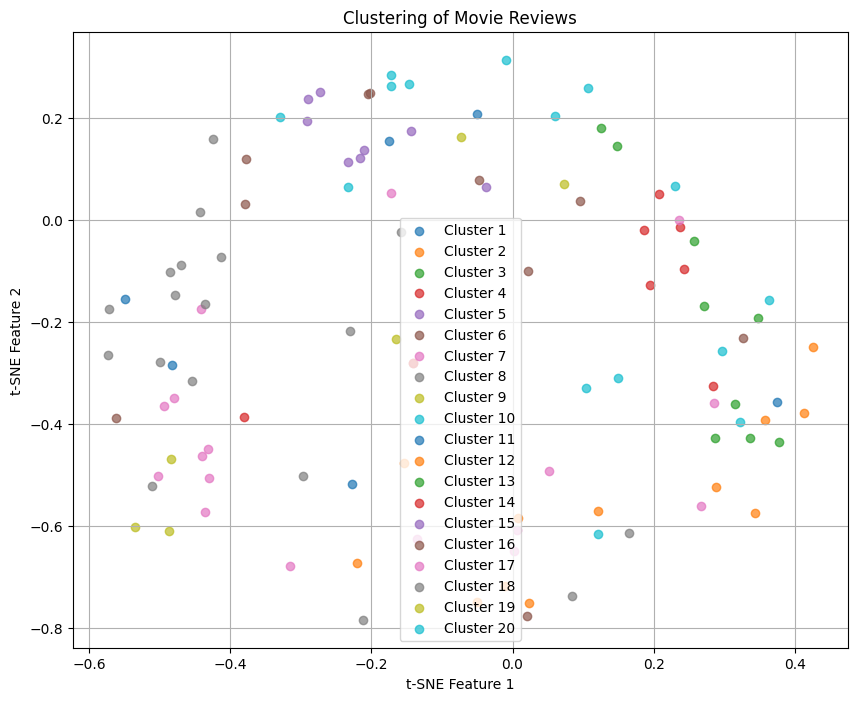

In [47]:
import matplotlib.pyplot as plt

# Plotting the 2D t-SNE results
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    plt.scatter(tsne_features[clusters == i, 0], tsne_features[clusters == i, 1], label=f'Cluster {i+1}', alpha=0.7)

plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.title('Clustering of Movie Reviews')
plt.legend()
plt.grid(True)
plt.show()

we have generated an cluster map, unfortunately our corpus seems to be a little bit too small with about 110 abstracts.  But so far we have validated that the logic and work flow behind this script is working and could work even better with a large set of data.